# Here, we will try to build a deeper neural network

In [65]:
# import required libraries
import numpy as np
import os, sys
import torch
# datasets
import torchvision.datasets as datasets
# transforms
import torchvision.transforms as transforms
# for plots
import matplotlib.pyplot as plt
# neural network modules
import torch.nn as nn
# PyTorch utilities
from torch.utils.data import DataLoader
# optimizers
import torch.optim as optim

import importlib

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
from src import utilities
from src.utilities import train_model, evaluate, plot_metrics, prediction_and_image, print_conclusion, realworld_prediction
importlib.reload(utilities)

<module 'src.utilities' from '/home/ravi/Desktop/deep-learning-projects/mnist-cnn/src/utilities.py'>

In [2]:
# set device to cuda(gpu)
device = torch.device("cuda")

In [ ]:
# define transform
transform = transforms.Compose(
    [
        transforms.ToTensor() # transform from the image datatype to PyTorch Tensors
    ]
)
# load the dataset
train_dataset = datasets.MNIST(root='../data', train=True, transform=transform)
test_dataset = datasets.MNIST(root='../data', train=False, transform=transform)

### Build a deeper CNN

In [4]:
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=24,kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Conv2d(in_channels=24,out_channels=48,kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        self.flatten = nn.Flatten()

        self.fc_linear_1 = nn.Linear(in_features=48*5*5, out_features=256)
        self.relu = nn.ReLU()

        self.fc_linear_2 = nn.Linear(in_features=256, out_features=10)
    
    def forward(self,X):
        X = self.conv1(X)
        X = self.relu(X)
        X = self.pool1(X)

        X = self.conv2(X)
        X = self.relu(X)
        X = self.pool2(X)

        X = self.flatten(X)
        X = self.fc_linear_1(X)
        X = self.relu(X)
        X = self.fc_linear_2(X)
        return X

### Train

EPOCH: 1...
EPOCH: 2...
EPOCH: 3...
EPOCH: 4...
EPOCH: 5...
EPOCH: 6...
EPOCH: 7...
EPOCH: 8...
EPOCH: 9...
EPOCH: 10...


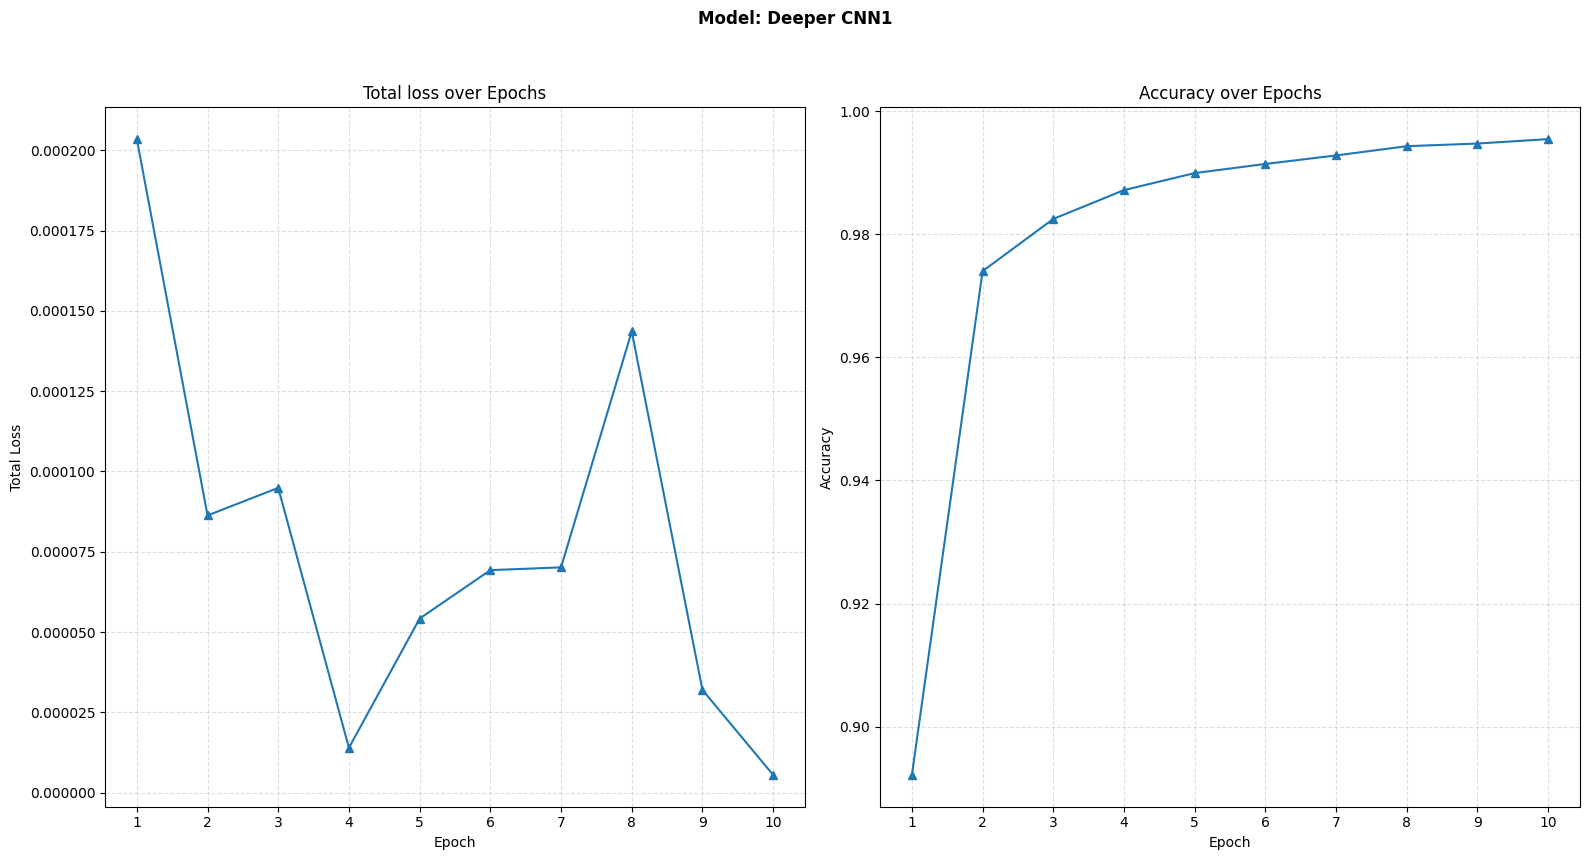

Model: Deeper CNN1
Loss(Training): 0.000006
Accuracy(Training): 0.995450
Loss(Testing): 0.022341
Accuracy(Testing): 0.993400


In [45]:
# instantiate the model and move to device
deeper_cnn_model_1 = CNN2().to(device)

# define batch size, dataloader, optimizer, and loss functions

# batch size
BATCHSIZE1 = 256
# dataloader
trainset_loader1 = DataLoader(train_dataset, BATCHSIZE1, shuffle=True)
testset_loader1 = DataLoader(test_dataset, BATCHSIZE1, shuffle=False)

# loss function (Cost Function)
loss_function = torch.nn.CrossEntropyLoss()

# optimizer - starting with the simplest one and with default learning rate
optimizer1 = optim.Adam(deeper_cnn_model_1.parameters())

EPOCHS = 10

# train the model
losses1, accuracies1 = train_model(deeper_cnn_model_1, trainset_loader1, loss_function, optimizer1, EPOCHS)

plot_metrics(losses1, accuracies1, "Deeper CNN1")

# Evaluate the model with test set
test_loss, test_accuracy = evaluate(deeper_cnn_model_1, testset_loader1, loss_function)

print_conclusion("Deeper CNN1", losses1, accuracies1, test_loss, test_accuracy)

### Evaluate

The image is of the digit (as recognized by our model): 5
The image is labelled as: 5 in the dataset.


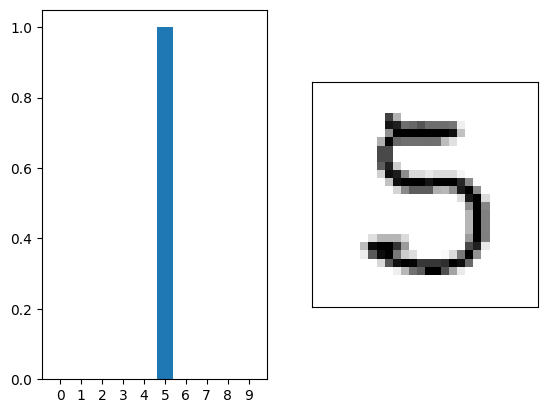

In [98]:
prediction_and_image(deeper_cnn_model_1, test_dataset)

In [ ]:
from PIL import Image, ImageOps

# Load the original image using Pillow
org_image = Image.open("../test.jpeg")

# Define a transform pipeline to convert to grayscale
# num_output_channels=1 ensures it's a single-channel image
transform_to_gray = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Lambda(lambda img: ImageOps.invert(img)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Apply the transformation
grayscale_tensor = transform_to_gray(org_image)
thresh = 0.76  # Equivalent to 128 in an 8-bit image (128/255 ≈ 0.5)
low_value = 0.0
high_value = 1.0
thresholded_tensor = torch.where(grayscale_tensor >= thresh, high_value, low_value)

# The output is a tensor, ready for your model
print(f"Shape of the grayscale tensor: {grayscale_tensor.shape}") # Should be [1, 28, 28]

to_pil = transforms.ToPILImage()
thresholded_image = to_pil(thresholded_tensor)
thresholded_image.show()

Shape of the grayscale tensor: torch.Size([1, 28, 28])


The image is of the digit (as recognized by our model): 4


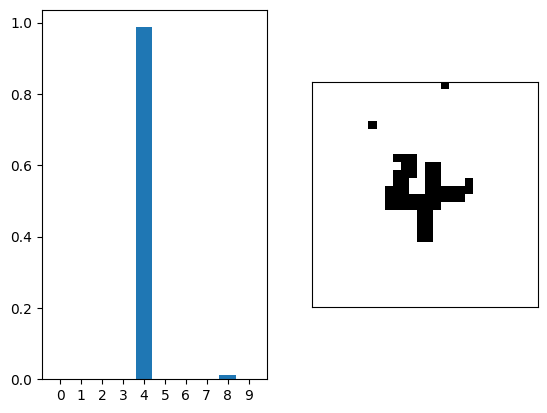

In [62]:
realworld_prediction(deeper_cnn_model_1, thresholded_tensor)

In [67]:
def realworld_prediction(model, test_image_tensor):
    test_image_tensor = test_image_tensor.to(device).unsqueeze(0)

    # put the model in evaluation (inference) mode
    model.eval()
    predictions_test_image_tensor = model(test_image_tensor)
    probabilities = torch.nn.functional.softmax(predictions_test_image_tensor, dim=1)
    probabilities = probabilities.cpu().detach().numpy() #.cpu() to copy tensor to memory first


    plt.Figure(figsize=(20,20))

    plt.subplot(1,2,1)
    classes = [i for i in range(10)]
    x_values = classes
    x_labels = [str(i) for i in x_values]
    plt.bar([i for i in range(10)], probabilities[0])
    plt.xticks(x_values, x_labels)

    plt.subplot(1,2,2)
    plt.imshow(test_image_tensor[0,0,:,:].cpu(), cmap=plt.cm.binary)
    plt.xticks([])
    plt.yticks([])

    model_output = np.argmax(probabilities)
    print(f"The image is of the digit (as recognized by our model): {model_output}")

In [130]:
# Load the original image using Pillow
org_image = Image.open("../ravi-handwritten-digits/0.jpg")

# Define a transform pipeline to convert to grayscale
# num_output_channels=1 ensures it's a single-channel image
transform_to_gray = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.Lambda(lambda img: ImageOps.invert(img)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Apply the transformation
grayscale_tensor = transform_to_gray(org_image)
thresh = 0.5  # Equivalent to 128 in an 8-bit image (128/255 ≈ 0.5)
low_value = 0.0
high_value = 1.0
thresholded_tensor = torch.where(grayscale_tensor >= thresh, high_value, low_value)

# The output is a tensor, ready for your model
print(f"Shape of the grayscale tensor: {grayscale_tensor.shape}") # Should be [1, 28, 28]

to_pil = transforms.ToPILImage()
thresholded_image = to_pil(grayscale_tensor)
thresholded_image.show()

Shape of the grayscale tensor: torch.Size([1, 28, 28])


The image is of the digit (as recognized by our model): 9


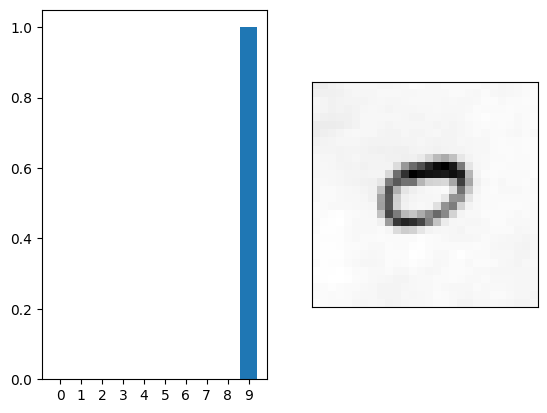

In [131]:
realworld_prediction(deeper_cnn_model_1, grayscale_tensor)